# Group Project Milestone 2: Data Exploration & Initial PreProcessing

In this assignment you will need to:

1. Create a GitHub ID
2. Create a GitHub Repository (Public or Private it is up to you. In the end it will have to be Public) and add your group members as collaborators
3. Perform the data exploration step (i.e. evaluate your data, # of observations, details about your data distributions, scales, missing data, column descriptions) Note: For image data you can still describe your data by the number of classes, # of images, plot example classes of the image, size of images, are sizes uniform? Do they need to be cropped? normalized? etc.
4. Plot your data. For tabular data, you will need to run scatters, for image data, you will need to plot your example classes.
5. How will you preprocess your data? You should explain this in your README.md file and link your Jupyter notebook to it. All code and  Jupyter notebooks have be uploaded to your repo.
6. You must also include in your Jupyter Notebook, a link for data download and environment setup requirements: 


!wget !unzip like functions as well as !pip install functions for non standard libraries not available in colab are required to be in the top section of your jupyter lab notebook. Or having the data on GitHub (you will need the academic license for GitHub to do this, larger datasets will require a link to external storage).

## GitHub ID

https://github.com/SmoothData-BigBrain

## Dataset link

https://www.kaggle.com/datasets/robikscube/flight-delay-dataset-20182022

## Data Exploration

Perform the data exploration step (i.e. evaluate your data, # of observations, details about your data distributions, scales, missing data, column descriptions) Note: For image data you can still describe your data by the number of classes, # of images, plot example classes of the image, size of images, are sizes uniform? Do they need to be cropped? normalized? etc.

### Import libraries

In [1]:
from pyspark import SparkContext

# Row used to create row objects for statistics table
from pyspark.sql import SparkSession, Row

In [2]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, isnan, when, count, isnull, abs, lit

In [3]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
spark = SparkSession.builder \
    .appName("Flight Data Analysis") \
    .getOrCreate()

spark.conf.set("spark.sql.debug.maxToStringFields", 1000)
spark.sparkContext.setLogLevel("ERROR")

### Read in dataset

#### read in individual raw files

In [5]:
import glob
import os
os.getcwd()

'/home/jovyan/work/PycharmProjects/DSC232R'

In [ ]:
home_dir = os.path.expanduser('~')
folder_path = os.path.join(home_dir, 'Desktop/GroupProject/data/archive/raw')
# folder_path = '~/Desktop/GroupProject/data/archive/raw'
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
df = spark.read.csv(csv_files,
                       sep = ',',
                       inferSchema = True,
                       header = True)

#### read in combined raw files

In [31]:
df = spark.read.csv('combined_file.csv', sep = ',', inferSchema = True, header = True)

#### read in dataset column description csv

In [8]:
col_des = spark.read.csv('flights_column_des.csv', sep = ',', inferSchema = True, header = True)

## Explore Dataset

### Get dataset shape

In [33]:
# get df shape
num_rows = df.count()
num_cols = len(df.columns)
print(f"Shape of the DataFrame: ({num_rows}, {num_cols})")

Shape of the DataFrame: (29193782, 120)


In [34]:
num_entries = df.count() #29193782
#num_entries = 29193782

### Explore null values

#### Column:Null Value Counts stored as a dictionary

In [35]:
#null_counts = df.select([count(col(c)).alias(c) for c in df.columns]).collect()[0].asDict()
#print(null_counts)

In [36]:
# compute count of non-null vals for each col in df
from pyspark.sql.functions import col, sum

null_counts = df.select([sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df.columns]) \
                .collect()[0] \
                .asDict()

print(null_counts)

{'Year': 0, 'Quarter': 0, 'Month': 0, 'DayofMonth': 0, 'DayOfWeek': 0, 'FlightDate': 0, 'Marketing_Airline_Network': 0, 'Operated_or_Branded_Code_Share_Partners': 0, 'DOT_ID_Marketing_Airline': 0, 'IATA_Code_Marketing_Airline': 0, 'Flight_Number_Marketing_Airline': 0, 'Originally_Scheduled_Code_Share_Airline': 29189909, 'DOT_ID_Originally_Scheduled_Code_Share_Airline': 29189909, 'IATA_Code_Originally_Scheduled_Code_Share_Airline': 29189909, 'Flight_Num_Originally_Scheduled_Code_Share_Airline': 29189909, 'Operating_Airline ': 0, 'DOT_ID_Operating_Airline': 0, 'IATA_Code_Operating_Airline': 0, 'Tail_Number': 267613, 'Flight_Number_Operating_Airline': 0, 'OriginAirportID': 0, 'OriginAirportSeqID': 0, 'OriginCityMarketID': 0, 'Origin': 0, 'OriginCityName': 0, 'OriginState': 0, 'OriginStateFips': 0, 'OriginStateName': 0, 'OriginWac': 0, 'DestAirportID': 0, 'DestAirportSeqID': 0, 'DestCityMarketID': 0, 'Dest': 0, 'DestCityName': 0, 'DestState': 0, 'DestStateFips': 0, 'DestStateName': 0, 'Des

In [37]:
# Dictionary indicates that the last several cols have all nulls, print last 10 cols of df to manually inspect if NULLS are present
df.select(df.columns[-10:]).show(5)

+-----------+-------------+----------------+------------+--------------+----------------+-------------+-----------+---------+------------+
|Div5Airport|Div5AirportID|Div5AirportSeqID|Div5WheelsOn|Div5TotalGTime|Div5LongestGTime|Div5WheelsOff|Div5TailNum|Duplicate|Unnamed: 119|
+-----------+-------------+----------------+------------+--------------+----------------+-------------+-----------+---------+------------+
|       NULL|         NULL|            NULL|        NULL|          NULL|            NULL|         NULL|       NULL|        N|        NULL|
|       NULL|         NULL|            NULL|        NULL|          NULL|            NULL|         NULL|       NULL|        N|        NULL|
|       NULL|         NULL|            NULL|        NULL|          NULL|            NULL|         NULL|       NULL|        N|        NULL|
|       NULL|         NULL|            NULL|        NULL|          NULL|            NULL|         NULL|       NULL|        N|        NULL|
|       NULL|         NULL|

In [38]:
# Dictionary indicates that the first several cols have no nulls, print first 10 cols of df to manually inspect if NULLS are present
df.select(df.columns[:10]).show(5)

+----+-------+-----+----------+---------+----------+-------------------------+---------------------------------------+------------------------+---------------------------+
|Year|Quarter|Month|DayofMonth|DayOfWeek|FlightDate|Marketing_Airline_Network|Operated_or_Branded_Code_Share_Partners|DOT_ID_Marketing_Airline|IATA_Code_Marketing_Airline|
+----+-------+-----+----------+---------+----------+-------------------------+---------------------------------------+------------------------+---------------------------+
|2020|      4|   10|        15|        4|2020-10-15|                       UA|                           UA_CODESHARE|                   19977|                         UA|
|2020|      4|   10|        23|        5|2020-10-23|                       UA|                           UA_CODESHARE|                   19977|                         UA|
|2020|      4|   10|        20|        2|2020-10-20|                       UA|                           UA_CODESHARE|                   199

#### Checking dataset for columns with few nulls or no nulls

In [ ]:
#columns_with_few_nulls = [col_name for col_name, count_val in null_counts.items() if count_val > 0.9*num_entries]
#columns_with_no_nulls = [col_name for col_name, count_val in null_counts.items() if count_val != 0]
#print(columns_with_few_nulls)
#print(columns_with_all_nulls)
#df.select(*columns_with_nulls).show()

#### Filtering dataset for columns with few nulls & viewing output

In [ ]:
#newdf = df.select(columns_with_few_nulls)
#newdf.select(newdf.columns[0:10]).show()

In [ ]:
#newdf.select(newdf.columns[10:19]).show()

In [ ]:
#newdf.select(newdf.columns[19:33]).show()

In [ ]:
#newdf.select(newdf.columns[33:50]).show()

In [ ]:
#newdf.select(newdf.columns[50:62]).show()

In [ ]:
## Count non-nulls in a list of specified columns

#repeat_cols = ["Marketing_Airline_Network", "Operated_or_Branded_Code_Share_Partners", "IATA_Code_Marketing_Airline", "Operating_Airline ", "IATA_Code_Operating_Airline"]
#print(newdf.select([count(col(c)).alias(c) for c in repeat_cols]).collect()[0].asDict())

In [ ]:
#print(newdf.select(repeat_cols).distinct().count())

In [ ]:
## filter dataset with cols to keep

#cols_to_keep = ["Year", "Month", "DayofMonth", "Origin", "OriginCityName", "DestCityName", "DepDelay", "ArrDelay", "Cancelled", "CRSElapsedTime", "ActualElapsedTime"]
#my_df = newdf.select(cols_to_keep)
#my_df.show()

#### Computing non-null counts as percentages

In [39]:
non_null_counts = df.select([count(col(c)).alias(c) for c in df.columns]).collect()[0].asDict()

# Calculate non-null percentages
non_null_percentages = {
    col_name: (count_val / num_entries) * 100
    for col_name, count_val in non_null_counts.items()
}

sorted_columns = sorted(non_null_percentages.items(), key=lambda x: x[1], reverse=True)

for col_name, pct in sorted_columns:
    print(f"{col_name}: {pct:.2f}% non-null")

Year: 100.00% non-null
Quarter: 100.00% non-null
Month: 100.00% non-null
DayofMonth: 100.00% non-null
DayOfWeek: 100.00% non-null
FlightDate: 100.00% non-null
Marketing_Airline_Network: 100.00% non-null
Operated_or_Branded_Code_Share_Partners: 100.00% non-null
DOT_ID_Marketing_Airline: 100.00% non-null
IATA_Code_Marketing_Airline: 100.00% non-null
Flight_Number_Marketing_Airline: 100.00% non-null
Operating_Airline : 100.00% non-null
DOT_ID_Operating_Airline: 100.00% non-null
IATA_Code_Operating_Airline: 100.00% non-null
Flight_Number_Operating_Airline: 100.00% non-null
OriginAirportID: 100.00% non-null
OriginAirportSeqID: 100.00% non-null
OriginCityMarketID: 100.00% non-null
Origin: 100.00% non-null
OriginCityName: 100.00% non-null
OriginState: 100.00% non-null
OriginStateFips: 100.00% non-null
OriginStateName: 100.00% non-null
OriginWac: 100.00% non-null
DestAirportID: 100.00% non-null
DestAirportSeqID: 100.00% non-null
DestCityMarketID: 100.00% non-null
Dest: 100.00% non-null
DestCit

#### **Discussion**

Dataset consists of columns with >90% non-null values and then it drops down to 0-17% non-null. Dataset to be used for further exploration will only include columns with >90% non-null values for more robust analysis

### Subset dataset - removing columns with <90% null values

In [40]:
columns_above_90 = [col_name for col_name, pct in non_null_percentages.items() if pct >= 90]
filtered_df = df.select(columns_above_90)
filtered_df.select(filtered_df.columns[:8]).show(5)

+----+-------+-----+----------+---------+----------+-------------------------+---------------------------------------+
|Year|Quarter|Month|DayofMonth|DayOfWeek|FlightDate|Marketing_Airline_Network|Operated_or_Branded_Code_Share_Partners|
+----+-------+-----+----------+---------+----------+-------------------------+---------------------------------------+
|2020|      4|   10|        15|        4|2020-10-15|                       UA|                           UA_CODESHARE|
|2020|      4|   10|        23|        5|2020-10-23|                       UA|                           UA_CODESHARE|
|2020|      4|   10|        20|        2|2020-10-20|                       UA|                           UA_CODESHARE|
|2020|      4|   10|        20|        2|2020-10-20|                       UA|                           UA_CODESHARE|
|2020|      4|   10|        17|        6|2020-10-17|                       UA|                           UA_CODESHARE|
+----+-------+-----+----------+---------+-------

In [45]:
# get filtered df shape
num_rows = filtered_df.count()
num_cols = len(filtered_df.columns)
print(f"Shape of the Filtered DataFrame removing cols w/ <90% null values: ({num_rows}, {num_cols})")

Shape of the Filtered DataFrame removing cols w/ <90% null values: (29193782, 62)


In [6]:
# save filtered df to not have to redo code later
#filtered_df.coalesce(1).write.mode("overwrite").option("header", True).csv("filtered_df_temp")

# read in already filtered_df saved previously
filtered_df = spark.read.csv('part-00000-b248588c-b561-414a-ba2c-bc77825e455a-c000.csv', sep = ',', inferSchema = True, header = True)

### Remaining Column Descriptions

In [9]:
col_des.count() # count original col number

119

In [10]:
# get all cols in filtered_df
filtered_cols = filtered_df.columns 

# remove any white space
filtered_cols = [str(c).strip() for c in filtered_cols]

# subset column description dataframe for only columns in filtered dataset
filtered_col_des = col_des.filter(col('column').isin(filtered_cols))

In [11]:
# check df was filtered correctly, length & row count should match
print(len(filtered_cols))
print(filtered_col_des.count())

62
62


In [12]:
# View all column descriptions in filtered dataframe

filtered_col_des.show(n=filtered_col_des.count(), truncate=False)

+---------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Column                                 |Description                                                                                                                                                                                                                                           |
+---------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Year                                   |Year                                                                                        

### Explore Dataset Statistics & Distributions

In [21]:
# get data type for each column
for name, dtype in filtered_df.dtypes:
    print(f"{name}: {dtype}")

Year: int
Quarter: int
Month: int
DayofMonth: int
DayOfWeek: int
FlightDate: date
Marketing_Airline_Network: string
Operated_or_Branded_Code_Share_Partners: string
DOT_ID_Marketing_Airline: int
IATA_Code_Marketing_Airline: string
Flight_Number_Marketing_Airline: int
Operating_Airline : string
DOT_ID_Operating_Airline: int
IATA_Code_Operating_Airline: string
Tail_Number: string
Flight_Number_Operating_Airline: int
OriginAirportID: int
OriginAirportSeqID: int
OriginCityMarketID: int
Origin: string
OriginCityName: string
OriginState: string
OriginStateFips: int
OriginStateName: string
OriginWac: int
DestAirportID: int
DestAirportSeqID: int
DestCityMarketID: int
Dest: string
DestCityName: string
DestState: string
DestStateFips: int
DestStateName: string
DestWac: int
CRSDepTime: int
DepTime: double
DepDelay: double
DepDelayMinutes: double
DepDel15: double
DepartureDelayGroups: double
DepTimeBlk: string
TaxiOut: double
WheelsOff: double
WheelsOn: double
TaxiIn: double
CRSArrTime: int
ArrTime

In [28]:
non_string_cols = [col_name for col_name, dtype in filtered_df.dtypes if dtype != 'string']

In [31]:
# subset column description dataframe for only non-string
non_string_col_des = filtered_col_des.filter(col('column').isin(non_string_cols))
non_string_col_des.show(n=non_string_col_des.count(), truncate=False)

+-------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Column                         |Description                                                                                                                                                                                                                                           |
+-------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Year                           |Year                                                                                                                        

### Discussion on skewed data distributions

When taking a look at the columns with the most amount of skew in the data distribution, columns that are ID inidicators or Flight numbers do not make sense to further investigations of data distributions. Although these are numerical values, they represent categorical variables as opposed to continuous. 

Columns with 'ID','Number', 'Origin', 'Dest' in the column name will be removed from statistical analysis to remove these categorical variables 

In [38]:
cont_col_des = non_string_col_des.filter(
    ~non_string_col_des['column'].rlike('Dest|Origin|ID|Number|FlightDate')
)
cont_col_des.show(n=cont_col_des.count(), truncate=False)

+--------------------+----------------------------------------------------------------------------------------------------------+
|Column              |Description                                                                                               |
+--------------------+----------------------------------------------------------------------------------------------------------+
|Year                |Year                                                                                                      |
|Quarter             |Quarter (1-4)                                                                                             |
|Month               |Month                                                                                                     |
|DayofMonth          |Day of Month                                                                                              |
|DayOfWeek           |Day of Week                                                         

In [39]:
# get statistics for all continuous variables
cont_cols = [row['column'] for row in cont_col_des.select('column').collect()]

describe_df = filtered_df.select(cont_cols).describe()

# compute Q1, Median, Q3 for each column
stats = {
    "25%": {},
    "50%": {},
    "75%": {}
}

for col_name in cont_cols:
    q1, median, q3 = filtered_df.approxQuantile(col_name, [0.25, 0.5, 0.75], 0.01)
    stats["25%"][col_name] = str(q1)
    stats["50%"][col_name] = str(median)
    stats["75%"][col_name] = str(q3)

# convert new rows to df rows
new_rows = [Row(summary=stat_name, **cols) for stat_name, cols in stats.items()]
quartile_df = spark.createDataFrame(new_rows)

# append the new rows to describe_df
full_summary_df = describe_df.unionByName(quartile_df)

In [40]:
# save df to not have to recalc results later
#print(os.getcwd())
full_summary_df.coalesce(1).write.mode("overwrite").option("header", True).csv("summary_output")

In [41]:
#full_summary_df = spark.read.csv('full_summary_df.csv', sep = ',', inferSchema = True, header = True)

In [49]:
full_summary_df.select(full_summary_df.columns[:6]).show(truncate=False)

+-------+------------------+-----------------+-----------------+------------------+------------------+
|summary|Year              |Quarter          |Month            |DayofMonth        |DayOfWeek         |
+-------+------------------+-----------------+-----------------+------------------+------------------+
|count  |29193782          |29193782         |29193782         |29193782          |29193782          |
|mean   |2019.8286552595343|2.448567986155408|6.327840462739634|15.751611250642346|3.9748785888721097|
|stddev |1.3425209248105185|1.121206305413525|3.452304681413265|8.778879077510561 |2.0023140280178704|
|min    |2018              |1                |1                |1                 |1                 |
|max    |2022              |4                |12               |31                |7                 |
|25%    |2019.0            |1.0              |3.0              |8.0               |2.0               |
|50%    |2020.0            |2.0              |6.0              |16.0     

In [48]:
# view df columns
full_summary_df.select(full_summary_df.columns[11:17]).show(truncate=False)

+--------------------+-----------------+------------------+------------------+-----------------+------------------+
|DepartureDelayGroups|TaxiOut          |WheelsOff         |WheelsOn          |TaxiIn           |CRSArrTime        |
+--------------------+-----------------+------------------+------------------+-----------------+------------------+
|28430698            |28413221         |28413231          |28400649          |28400639         |29193782          |
|-0.01609496186129514|16.71093794681004|1352.8449158422004|1463.2619792244889|7.532168695218442|1489.0039230271707|
|2.164260832218235   |9.391262236498871|496.18267973455   |521.5568417416478 |6.09250097936616 |507.2880292230891 |
|-2.0                |0.0              |1.0               |1.0               |0.0              |1                 |
|12.0                |1394.0           |2400.0            |2400.0            |316.0            |2400              |
|-1.0                |11.0             |932.0             |1049.0       

### Explore skewed data

mean > median, data is right-skewed (longer tail on the right)
median < mean, data is left-skewed (longer tail on the left)

This code is to find top 20 features with largest skews. These features will then be plotted in histograms

The purpose of doing this is to understand if there are any outliers in the dataset that may be worth removing from the dataset prior to applying ML methods

### Explore data distributions

In [43]:
# get mean and median rows as dicts
mean_row = full_summary_df.filter(col("summary") == "mean").collect()[0].asDict()
median_row = full_summary_df.filter(col("summary") == "50%").collect()[0].asDict()

# skip the 'summary' key
cols = [col for col in mean_row.keys() if col != "summary"]

# build rows of (column, absolute_diff, skew direction)
result_rows = []
for c in cols: # for each col
    mean_val = float(mean_row[c]) # get mean
    median_val = float(median_row[c]) # get median
    diff = __builtins__.abs(mean_val - median_val) # get abs difference
    skew = "right" if mean_val > median_val else "left" if mean_val < median_val else "none" # get skew direction
    result_rows.append(Row(column=c, absolute_diff=diff, skew=skew)) # aggregate

# create df
diff_df = spark.createDataFrame(result_rows)

# get top 20
top_skewed = diff_df.orderBy(col("absolute_diff").desc()).limit(20)

top_skewed.show(truncate=False)


+--------------------+-------------------+-----+
|column              |absolute_diff      |skew |
+--------------------+-------------------+-----+
|Distance            |155.73456539478173 |right|
|WheelsOn            |36.73802077551113  |left |
|ArrTime             |33.95374316138236  |left |
|CRSArrTime          |24.996076972829314 |left |
|WheelsOff           |19.844915842200407 |right|
|AirTime             |18.087502934330175 |right|
|CRSElapsedTime      |17.760511527120855 |right|
|ActualElapsedTime   |17.29412005618005  |right|
|ArrDelayMinutes     |12.809917023307689 |right|
|DepDelayMinutes     |12.783107329971287 |right|
|DepDelay            |11.30686640194342  |right|
|ArrDelay            |10.609370268007531 |right|
|CRSDepTime          |9.26173837291799   |right|
|DepTime             |7.295567127752975  |right|
|TaxiOut             |2.7109379468100414 |right|
|TaxiIn              |1.5321686952184423 |right|
|DepartureDelayGroups|0.9839050381387049 |right|
|ArrivalDelayGroups 

In [44]:
# get all cols in filtered_df
skewed_cols = [row['column'] for row in top_skewed.select('column').collect()]

# remove any white space
skewed_cols = [str(c).strip() for c in skewed_cols]

# subset column description dataframe for only columns in filtered dataset
skewed_col_des = col_des.filter(col('column').isin(skewed_cols))

In [45]:
skewed_col_des.show(n=skewed_col_des.count(), truncate=False)

+--------------------+----------------------------------------------------------------------------------------------------------+
|Column              |Description                                                                                               |
+--------------------+----------------------------------------------------------------------------------------------------------+
|Quarter             |Quarter (1-4)                                                                                             |
|CRSDepTime          |CRS Departure Time (local time: hhmm)                                                                     |
|DepTime             |Actual Departure Time (local time: hhmm)                                                                  |
|DepDelay            |Difference in minutes between scheduled and actual departure time. Early departures show negative numbers.|
|DepDelayMinutes     |Difference in minutes between scheduled and actual departure time. E

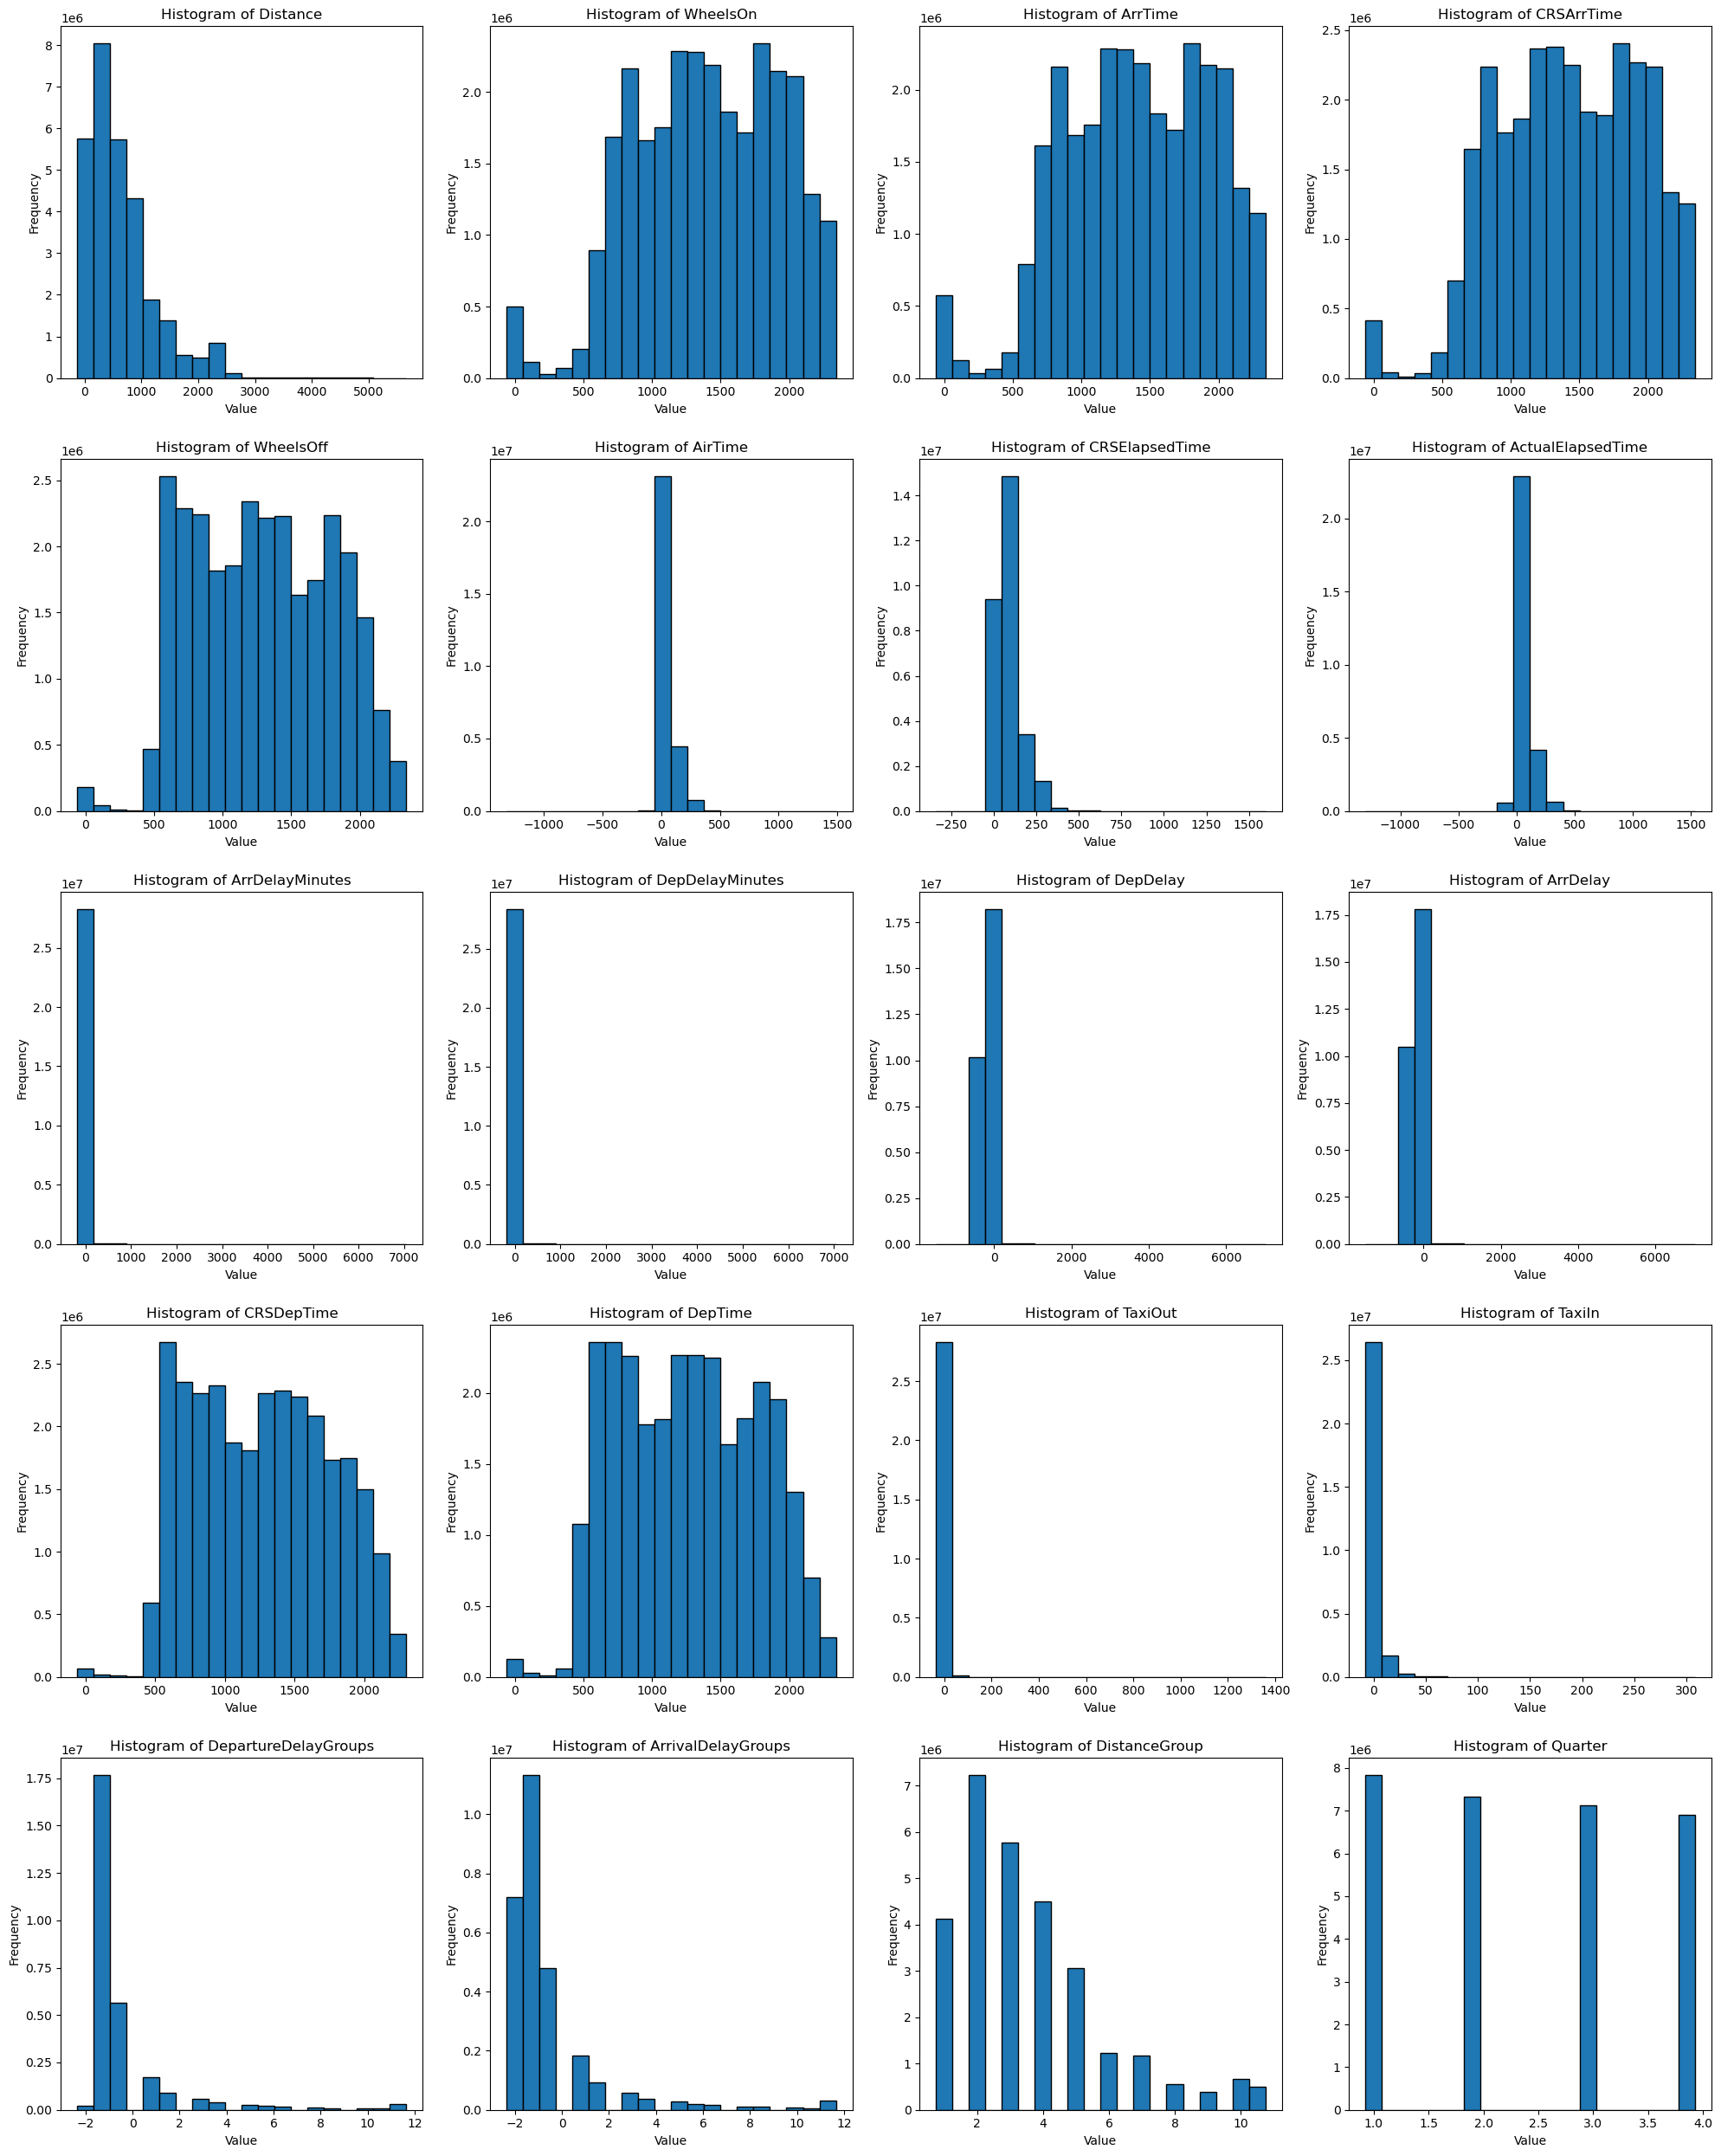

In [46]:
# list of columns from 'top_skewed'
columns_to_plot = [row['column'] for row in top_skewed.collect()]

# filter the columns that exist in filtered_df
valid_columns = [col for col in columns_to_plot if col in filtered_df.columns]

# plot histograms for each column
n_cols = 4  # 4 histograms per row
n_rows = (len(valid_columns) + n_cols - 1) // n_cols  # calculate num rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))

# flatten axes for easier indexing
axes = axes.flatten()

# loop through cols and plot
for i, column in enumerate(valid_columns):
    hist = filtered_df.select(column).rdd.flatMap(lambda x: x).histogram(20)  # 20 bins
    
    bin_edges, bin_counts = hist

    # plot the histogram using the bin edges and counts
    axes[i].bar(bin_edges[:-1], bin_counts, width=(bin_edges[1] - bin_edges[0]), edgecolor='black')

    # set axes & title
    axes[i].set_title(f"Histogram of {column}")
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# turn off any unused subplots
for i in range(len(valid_columns), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Discussion

The distance column, majority of flights in this dataset have a distance <1000 miles. With a few outliers ranging from 3000-5000 miles. 

Wheels On & Wheels Off time and CRSDepTime & DepTime columns have a few outliers at 0:00-4:00am, majority of times are listed between 5:00 & 23:59

The majority of TaxiOut and TaxiIn times are around 0 (or <50minutes). However, there are outliers sitting at ~1300 & 300 minutes respectively. 

## Which Origin Cities had the most delayed flights?

In [ ]:
count_delay = my_df.select(["Origin", "DepDelay"]).groupBy("Origin")\
        .agg(count(F.when(col("DepDelay") > 0, 1)).alias("DelayCount"), 
             count(F.when(col("DepDelay") < 0, 1)).alias("EarlyCount"),
            count("*").alias("TotalCount")).orderBy(col("TotalCount").desc())
pandas_delay = count_delay.toPandas()

In [ ]:
pdf = pandas_delay.copy()
pdf["OnTimeCount"] = pdf["TotalCount"] - pdf["DelayCount"] - pdf["EarlyCount"]

In [ ]:
top_20 = pdf.head(20)
top_20

In [ ]:
count_delay = my_df.select(["Origin", "DepDelay"]).groupBy("Origin")\
        .agg(count(F.when(col("DepDelay") > 0, 1)).alias("DelayCount"), 
             count(F.when(col("DepDelay") < 0, 1)).alias("EarlyCount"),
            count("*").alias("TotalCount")).orderBy(col("TotalCount").desc())
pandas_delay = count_delay.toPandas()# Assuming pdf has these columns: OriginCity, DelayedFlights, EarlyFlights, OnTimeFlights

# Bar positions
cities = top_20["Origin"]
x = np.arange(len(cities))

# Heights
early = top_20["EarlyCount"]
on_time = top_20["OnTimeCount"]
delayed = top_20["DelayCount"]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(x, early, label="Early", color="green")
plt.bar(x, on_time, bottom=early, label="On Time", color="gray")
plt.bar(x, delayed, bottom=early + on_time, label="Delayed", color="red")

# Labels and formatting
plt.xticks(x, cities, rotation=45)
plt.ylabel("Number of Flights")
plt.title("Flight Status by Origin City (Top 20)")
plt.legend(title="Flight Status")
plt.tight_layout()
plt.show()

In [ ]:
year_delay = my_df.select(["Year", "DepDelay"]).groupBy("Origin")\
        .agg(count(F.when(col("DepDelay") > 0, 1)).alias("DelayCount"), 
             count(F.when(col("DepDelay") < 0, 1)).alias("EarlyCount"),
            count("*").alias("TotalCount")).orderBy(col("TotalCount").desc())
pandas_year_delay = count_delay.toPandas()